<a href="https://colab.research.google.com/github/288756/VisArtificial/blob/master/Aprofundo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
import tensorflow as tf
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Montar el Google Drive en el directorio del proyecto y descomprimir el fichero con los datos
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/aprendizaje-profundo.zip' >> /dev/null  # ACTUALIZAR: ruta al fichero comprimido


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Mounted at /content/gdrive


In [2]:
data_path = '/content/NIPS4B'
audiostrain_dir = data_path + "/train/"
csvtrain_file = data_path + "/train.csv"

imgtest_dir = data_path + "/test/"
csvtest_file = data_path + "/test.csv"

class_infodir = data_path + "/class_info.csv"

In [3]:
class_info = pd.read_csv(class_infodir)
dftrain = pd.read_csv(csvtrain_file)
dftest = pd.read_csv(csvtest_file)
dftrain

,filename,start,end,class
0,nips4b_train001.wav,2.975057,3.172426,Petpet_song
1,nips4b_train001.wav,1.967891,2.054966,Sylcan_song
2,nips4b_train001.wav,0.856236,0.937506,Sylcan_song
3,nips4b_train001.wav,1.541224,1.674739,Sylcan_song
4,nips4b_train001.wav,1.843084,1.973696,Sylcan_song
...,...,...,...,...
4583,nips4b_train525.wav,3.662041,3.707755,Poepal_call
4584,nips4b_train525.wav,3.732245,3.877551,Poepal_call
4585,nips4b_train525.wav,4.236735,4.337959,Poepal_call
4586,nips4b_train525.wav,2.091429,2.210612,Unknown


In [4]:
class_info

,class name,English_name,Scientific_name,type
0,Aegcau_call,Long-tailed Tit,Aegithalos caudatus,bird
1,Alaarv_song,Eurasian Skylark,Alauda arvensis,bird
2,Anttri_song,Tree Pipit,Anthus trivialis,bird
3,Butbut_call,Common Buzzard,Buteo buteo,bird
4,Carcan_call,Common Linnet,Linaria cannabina,bird
...,...,...,...,...
84,Turmer_call,Common Blackbird,Turdus merula,bird
85,Turmer_song,Common Blackbird,Turdus merula,bird
86,Turphi_call,Song Thrush,Turdus philomelos,bird
87,Turphi_song,Song Thrush,Turdus philomelos,bird


In [7]:
# Calcular la duración de los segmentos de canto
dftrain['duration'] = dftrain['end'] - dftrain['start']
dftrain

,filename,start,end,class,duration
0,nips4b_train001.wav,2.975057,3.172426,Petpet_song,0.197370
1,nips4b_train001.wav,1.967891,2.054966,Sylcan_song,0.087075
2,nips4b_train001.wav,0.856236,0.937506,Sylcan_song,0.081270
3,nips4b_train001.wav,1.541224,1.674739,Sylcan_song,0.133515
4,nips4b_train001.wav,1.843084,1.973696,Sylcan_song,0.130612
...,...,...,...,...,...
4583,nips4b_train525.wav,3.662041,3.707755,Poepal_call,0.045714
4584,nips4b_train525.wav,3.732245,3.877551,Poepal_call,0.145306
4585,nips4b_train525.wav,4.236735,4.337959,Poepal_call,0.101224
4586,nips4b_train525.wav,2.091429,2.210612,Unknown,0.119184


In [8]:
missing_data = dftrain.isnull().sum()
print(missing_data)
# Contar la cantidad de muestras por clase
class_counts = dftrain['class'].value_counts()
print(class_counts)

filename    0
start       0
end         0
class       0
duration    0
dtype: int64
class
Sylcan_song    201
Unknown        194
Sylund_song    191
Sylmel_call    180
Lularb_song    175
              ... 
Cicorn_song      9
Plasab_song      9
Phycol_call      9
Jyntor_song      9
Cicatr_song      7
Name: count, Length: 89, dtype: int64


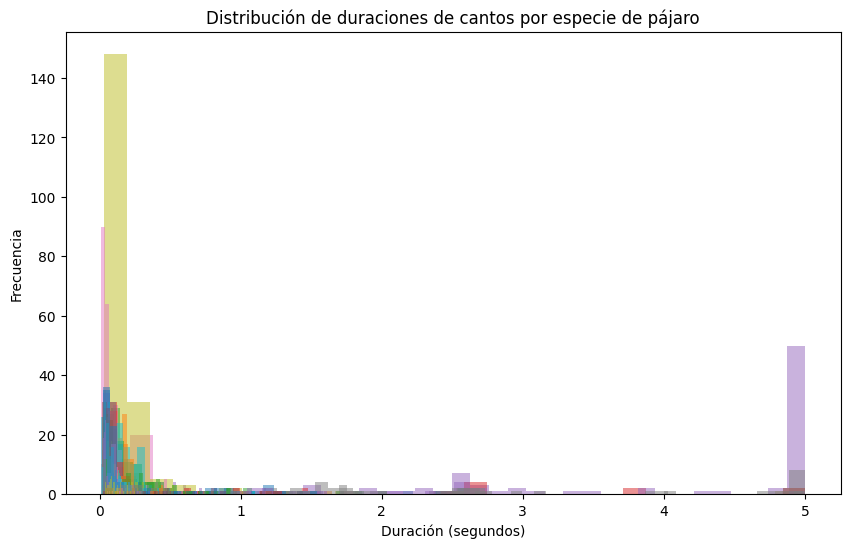

In [9]:
import matplotlib.pyplot as plt

# Histograma de las duraciones de los cantos para cada clase
plt.figure(figsize=(10, 6))
for species in dftrain['class'].unique():
    durations = dftrain[dftrain['class'] == species]['duration']
    plt.hist(durations, bins=30, alpha=0.5, label=species)
plt.xlabel('Duración (segundos)')
plt.ylabel('Frecuencia')
plt.title('Distribución de duraciones de cantos por especie de pájaro')
plt.show()

In [25]:
label_encoder = LabelEncoder()
dftrain['class'] = label_encoder.fit_transform(dftrain['class'])

import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

def generate_spectrograms(dataframe, audio_dir, n_fft=256, hop_length=128, n_mels=32, fmax=8000):
    spectrograms = []

    for index, row in dataframe.iterrows():
        audio_file = os.path.join(audio_dir, row['filename'])
        start_time = row['start']
        end_time = row['end']

        # Cargar el archivo de audio
        y, sr = librosa.load(audio_file, sr=None, offset=start_time, duration=end_time - start_time)

        # Calcular el espectrograma
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)

        # Agregar el espectrograma a la lista junto con la clase y otra información relevante
        spectrograms.append((spectrogram, row['class'], start_time, end_time))

    return spectrograms

# Generar espectrogramas
spectrograms = generate_spectrograms(dftrain, audiostrain_dir, n_fft=256, hop_length=128)


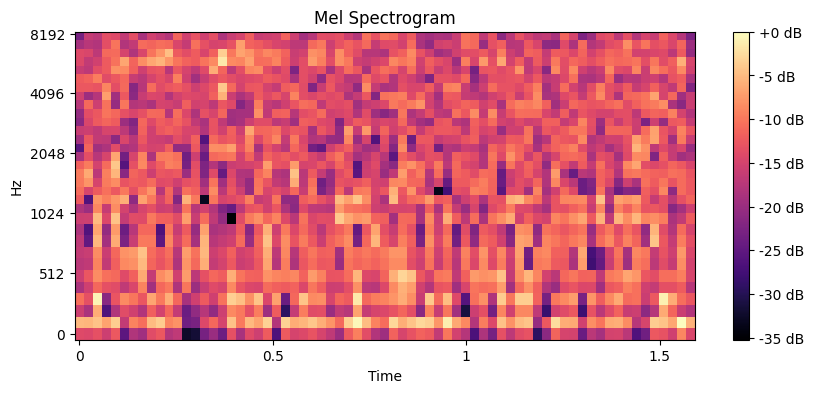

In [26]:
import librosa.display
import matplotlib.pyplot as plt

# Seleccionar un espectrograma de la lista (por ejemplo, el primero)
example_spectrogram = spectrograms[0][0]

# Mostrar el espectrograma
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(example_spectrogram, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()